In [1]:
import glob
import os
import warnings
import numpy as np  # type: ignore
import xarray as xr  # type: ignore
import xesmf as xe  # type: ignore
from pathlib import Path
from dask.diagnostics import ProgressBar
from dask.distributed import Client  # type: ignore
import dask.array as da
from scipy.interpolate import interp1d  # type: ignore
import yaml
warnings.simplefilter("ignore", UserWarning)
# c = Client(n_workers=48)
c = Client()
c

2024-05-17 15:29:45,438 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-05-17 15:29:45,441 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-05-17 15:29:45,445 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0090.gadi.nci.org.au/64026/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0090.gadi.nci.org.au/64026/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35587,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0090.gadi.nci.org.au/64026/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43085,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0090.gadi.nci.org.au/64026/proxy/45187/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43375,


In [2]:
# Input start --------------------------------------------------------------
input_path = (
    "/g/data/rt52/era5/pressure-levels/reanalysis"  # Path to the ERA5 reanalysis data
)
# target_path = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1"  # Path to the target GCM dataset
target_path = (
    "/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/historical/r1i1p1f2"
) # Path to the GCM datasets
output_path = (
    "/scratch/dm6/yk8692/interpolation/tested_v2"  # Path to save the output files
)
yaml_path = (
    "/scratch/dm6/yk8692/sdmbc/user_input_test_interpolation.yaml"
)

input_variables = ["q", "t", "u", "v"]  # 3D variables of ERA5
target_variables = ["hus", "ta", "ua", "va"]  # 3D variables of GCM

# Target gcm information --------------------------------------------------
infor = "6hrLev"
gname = "CNRM-CM6-1"  # EC-Earth3-Veg, ACCESS-ESM1-5
period = "historical"
cinfor = "r1i1p1f2"  # r1i1p1f1
sinfor = "gr"  # gn, gr
version = "v20180917"  # v20180917, v20191115

start_year = 2000  # Start year for interpolation
end_year = 2000  # End year for interpolation
start_month = 1
end_month = 1
var_interp = 'ta' # Target variable
# Input end ---------------------------------------------------------------

In [3]:
class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


with open(f"{yaml_path}", "r") as file:
    config_data = yaml.safe_load(file)

config = Config(**config_data)

lat_max = config.lat_max
lat_min = config.lat_min
lon_max = config.lon_max
lon_min = config.lon_min
input_path = config.input_path
target_path = config.target_path
output_path = config.output_path
input_z_path = config.input_z_path
infor = config.infor
gname = config.gname
period = config.period
cinfor = config.cinfor
sinfor = config.sinfor
version = config.version
input_infor = config.input_infor
input_gname = config.input_gname
input_sinfor = config.input_sinfor
input_version = config.input_version
input_model = config.input_model
# start_year = config.startyear_h
# end_year = config.endyear_h

In [4]:
# Define functions for the horizontal and vertical interpolation ----------------
def geopotential_to_geopotential_height(g):
    """
    Calculate geopotential height from the geopotential variable.

    Parameters:
    g (float): The geopotential variable from ERA5, in m^2 s^-2.

    Returns:
    float: The geopotential height Z, in meters.

    Formula:
    The geopotential height Z is calculated as Z = g / g0, where g0 = 9.80665 m/s^2.
    """
    g0 = 9.80665
    Z = g / g0
    return Z


def calculate_hybrid_height(a, b, orog):
    """
    Calculates the hybrid height using coefficients from the GCM dataset and the surface orography.

    Parameters:
    a (float): Coefficient 'a' from the GCM dataset.
    b (float): Coefficient 'b' from the GCM dataset.
    orog (float): Surface orography.

    Returns:
    float: The calculated hybrid height.

    """
    z = a + b * orog
    return z


def calculate_pressure_levels(ap, b, ps):
    """
    Calculate pressure at each model level by automatically broadcasting 'ap' and 'b'
    against 'ps' across their shared dimensions ('lat', 'lon') and aligning them with
    'ps' time dimension.

    Parameters:
    - ap: Xarray DataArray of 'ap' coefficient, shaped [lev]
    - b: Xarray DataArray of 'b' coefficient, shaped [lev]
    - ps: Xarray DataArray of surface pressure, shaped [time, lat, lon]

    Returns:
    - p_levels: Xarray DataArray of pressure at each model level, shaped [time, lev, lat, lon]
    """

    # Ensure 'ap' and 'b' are broadcasted and aligned along 'ps' dimensions
    # This uses Xarray's automatic alignment and broadcasting
    ap_expanded = ap * xr.ones_like(
        ps
    )  # This automatically broadcasts 'ap' across 'ps' dimensions
    b_expanded = b * xr.ones_like(ps)  # Similarly for 'b'

    # Calculate pressure at each model level
    p_levels = ap_expanded + b_expanded * ps
    return p_levels


def compute_geopotential_height(p_levels, T_levels, q_levels=None):
    Rd = 287.05  # J/kg/K, specific gas constant for dry air
    g = 9.80665  # m/s^2, acceleration due to gravity

    # Ensure T_levels and q_levels are DataArrays for compatibility with xarray operations
    if isinstance(T_levels, xr.DataArray):
        T_levels = T_levels
    else:
        T_levels = xr.DataArray(T_levels)

    if q_levels is not None and not isinstance(q_levels, xr.DataArray):
        q_levels = xr.DataArray(q_levels)

    # Compute the pressure ratio without aligning by levels
    upper_p = p_levels.isel(lev=slice(None, -1)).data
    lower_p = p_levels.isel(lev=slice(1, None)).data
    p_ratio = upper_p / lower_p
    log_p_ratio = da.log(p_ratio)

    # Re-create the DataArray for log_p_ratio with adjusted coordinates
    log_p_ratio_da = xr.DataArray(
        log_p_ratio,
        dims=["time", "lev", "lat", "lon"],
        coords={
            "time": p_levels.time,
            "lev": p_levels.lev[:-1],  # Use coordinates from the upper slice
            "lat": p_levels.lat,
            "lon": p_levels.lon,
        },
    )

    # Compute mean temperature between consecutive levels without alignment
    upper_T = T_levels.isel(lev=slice(None, -1)).data
    lower_T = T_levels.isel(lev=slice(1, None)).data
    mean_T = (upper_T + lower_T) / 2

    # Re-create the DataArray for mean_T with adjusted coordinates
    mean_T_da = xr.DataArray(
        mean_T,
        dims=["time", "lev", "lat", "lon"],
        coords=log_p_ratio_da.coords,  # Match coordinates with log_p_ratio_da
    )
    if q_levels is not None:
        # Compute moist temperature
        upper_q = q_levels.isel(lev=slice(None, -1)).data
        lower_q = q_levels.isel(lev=slice(1, None)).data
        mean_q = (upper_q + lower_q) / 2
        # Re-create the DataArray for mean_T with adjusted coordinates
        mean_q_da = xr.DataArray(
            mean_q,
            dims=["time", "lev", "lat", "lon"],
            coords=log_p_ratio_da.coords,  # Match coordinates with log_p_ratio_da
        )
        mean_T_da = mean_T_da * (1.0 + 0.609133 * mean_q_da)

    # Calculate thickness of each layer (delta Z)
    delta_Z = (Rd / g) * mean_T_da * log_p_ratio_da

    # Integrate delta_Z from the top to obtain geopotential heights
    Z_levels_cumsum = delta_Z.cumsum(dim="lev")
    
    # Add an extra level at the top with zero or extrapolated geopotential height
    top_level = da.zeros(
        (
            Z_levels_cumsum.shape[0],
            1,
            Z_levels_cumsum.shape[2],
            Z_levels_cumsum.shape[3],
        ),
        dtype=Z_levels_cumsum.dtype,
    )
    Z_levels = da.concatenate([top_level, Z_levels_cumsum], axis=1)

    # Update level coordinates to include the top level
    Z_levels = xr.DataArray(
        Z_levels,
        dims=["time", "lev", "lat", "lon"],
        coords={
            "time": p_levels.time,
            "lev": p_levels.lev,  # Use original levels, assuming the extra level is added at the top
            "lat": p_levels.lat,
            "lon": p_levels.lon,
        },
        name="zfull",
    )

    return Z_levels


def custom_interp(x_new, interp_func, x_min, x_max):
    """
    Custom interpolation function that extrapolates for lower bounds and fills NaN for upper bounds.

    Args:
        x_new (array-like): The target levels to interpolate the source profile to.
        interp_func (callable): The interpolation function.
        x_min (float): The minimum value of the original x data.
        x_max (float): The maximum value of the original x data.

    Returns:
        array-like: The interpolated values with custom handling for extrapolation.
    """
    y_new = interp_func(x_new)
    # Identify indices where extrapolation happens
    lower_bound = x_new < x_min
    upper_bound = x_new > x_max

    # Fill NaN for upper bound
    y_new[upper_bound] = np.nan

    return y_new


def interpolate_profile(source_profile, source_levels, target_levels):
    """
    Interpolates a source profile to match target levels with custom handling for extrapolation.

    Args:
        source_profile (array-like): The source profile to be interpolated.
        source_levels (array-like): The levels corresponding to the source profile.
        target_levels (array-like): The target levels to interpolate the source profile to.

    Returns:
        array-like: The interpolated profile matching the target levels.
    """
    # Create the interpolation function with 'extrapolate' mode
    f_interp = interp1d(
        source_levels, source_profile, bounds_error=False, fill_value="extrapolate"
    )

    # Get the min and max of source levels
    x_min = np.min(source_levels)
    x_max = np.max(source_levels)

    return custom_interp(target_levels, f_interp, x_min, x_max)


# Assuming ds_regridded, Z_era5, and gcm_z_data are xarray DataArrays/Datasets with Dask arrays
def vertical_interpolation(source_da, source_levels_da, target_levels):
    """
    Perform vertical interpolation of a source data array to target levels using xarray's apply_ufunc.

    Parameters:
        source_da (xarray.DataArray): The source data array to be interpolated.
        source_levels_da (xarray.DataArray): The source data array's levels.
        target_levels (array-like): The target levels to interpolate to.

    Returns:
        xarray.DataArray: The interpolated data array.

    """
    # Wrapper to apply interpolation using xarray's apply_ufunc to handle Dask arrays efficiently
    interpolated_da = xr.apply_ufunc(
        interpolate_profile,
        source_da,
        source_levels_da,
        target_levels,
        vectorize=True,  # Enable vectorized execution
        input_core_dims=[["level"], ["level"], ["lev"]],  # Define core dimensions
        output_core_dims=[["lev"]],  # Define output dimensions
        dask="parallelized",  # Enable Dask parallelization
        output_dtypes=[source_da.dtype],
    )

    # return interpolated_da
    return interpolated_da.assign_coords(lev=target_levels.lev)


def correct_latitudes(ds):
    # Ensure latitudes are within bounds
    ds["latitude"] = ds["latitude"].clip(-90, 90)
    return ds


# Horizontal interpolation
def regrid(source_ds, target_ds, method, weights_path, rename_dict):
    """
    Perform interpolation/regridding of a source dataset to a target dataset using the specified method.

    Args:
        source_ds (xarray.DataArray or xarray.Dataset): The source dataset to be regridded.
        target_ds (xarray.Dataset): The target dataset with the desired grid.
        method (str): The interpolation method to be used. Supported methods: 'bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch', 'nearest_s2d', 'nearest_d2s', 'patch'.
        weights_path (str): The path to the weights file used for regridding. If the file exists, the weights will be reused. If not, the weights will be computed and saved to this path.
        rename_dict (dict): A dictionary mapping variable names in the source dataset to the desired variable names in the regridded dataset.

    Returns:
        xarray.Dataset: The regridded dataset with variables renamed according to the provided rename_dict.

    """
    weights_file = Path(weights_path)
    reuse_weights = weights_file.is_file()
    regridder = xe.Regridder(
        source_ds,
        target_ds,
        method=method,
        filename=weights_path,
        reuse_weights=reuse_weights,
    )
    if isinstance(source_ds, xr.DataArray):
        # Handling for DataArray
        if source_ds.name != "zfull":
            regridded_data = regridder(source_ds)
            # Rename the DataArray if necessary
            if source_ds.name in rename_dict:
                regridded_data.name = rename_dict[source_ds.name]
            return regridded_data
        return source_ds
    elif isinstance(source_ds, xr.Dataset):
        # Handling for Dataset
        regridded_data = regridder(source_ds)
        # Check and rename variables in the Dataset if necessary
        for var in list(regridded_data.data_vars):
            if var in rename_dict:
                regridded_data = regridded_data.rename({var: rename_dict[var]})
        return regridded_data
    else:
        raise TypeError("Input must be xarray DataArray or Dataset")


def standardize_coords(ds):
    # Define the desired name mappings
    coord_map = {"lon": "longitude", "lat": "latitude", "lev": "level"}
    # Prepare to modify the dataset
    new_ds = ds.copy()

    # Check and handle each coordinate in the map
    for old_name, new_name in coord_map.items():
        if old_name in new_ds.coords:
            if new_name in new_ds.coords:
                # Both old and new coordinates exist
                # print(f"Both '{old_name}' and '{new_name}' exist.")
                # Check if they are identical to decide on merging or replacing
                if xr.all(new_ds[old_name] == new_ds[new_name]):
                    # If identical, drop the old coordinate
                    new_ds = new_ds.drop_vars(old_name)
                    # print(f"Dropped '{old_name}' as it is identical to '{new_name}'.")
                # else:
                # If not identical, consider how to merge or rename to avoid conflict
                # print(f"Coordinates '{old_name}' and '{new_name}' are not identical. Consider merging or manually handling.")
            else:
                # Safe to rename as the new name does not exist
                new_ds = new_ds.rename({old_name: new_name})
                # print(f"Renamed '{old_name}' to '{new_name}'.")
        # else:
        # print(f"'{old_name}' not found in the coordinates; no changes made.")

    return new_ds

In [5]:
%%time

for year in range(start_year, end_year + 1):

    # Define patterns to match files from the current and previous year
    current_year_pattern = f"{year}*.nc"
    selected_variables = [var_interp]
    tq_variables = ["ta", "hus"]

    # Glob patterns for target files, considering the necessary period from the previous year
    target_files = {
        var: sorted(
            glob.glob(
                f"{target_path}/{infor}/{var}/{sinfor}/{version}/{var}_*{current_year_pattern}"
            )
        )
        for var in selected_variables
    }
    tq_files = {
        var: sorted(
            glob.glob(
                f"{target_path}/{infor}/{var}/{sinfor}/{version}/{var}_*{current_year_pattern}"
            )
        )
        for var in tq_variables
    }
    # Start monthly loop ----------------------------------------
    for month in range(start_month, end_month + 1):  # Loop through all months
        # Load the target grid with preprocessing
        target_grids = {}
        for var in selected_variables:
            # Load the dataset combining files by coordinates
            with xr.open_dataset(target_files[var][0]) as temp_ds:
                # Determine chunking strategy based on dimensions
                chunks = {dim: "auto" for dim in temp_ds.dims}

            ds = xr.open_mfdataset(
                target_files[var],
                combine="by_coords",
                chunks=chunks,
            )
            # Select data for a specific month and year
            # Ensure time decoding is correct (if not automatically handled by xarray)
            ds = xr.decode_cf(ds)
            selected_ds = ds.sel(
                time=(ds["time"].dt.year == year) & (ds["time"].dt.month == month)
            )
            selected_ds["lat"] = selected_ds["lat"].clip(-90, 90)

            # Check if any data is selected to prevent processing empty datasets
            if selected_ds.sizes["time"] == 0:
                raise ValueError(
                    f"No data available for {year}-{month} in variable {var}."
                )

            # Store the selected dataset in the dictionary
            target_grids[var] = selected_ds

        tq_grids = {}
        for var in tq_variables:
            # Load the dataset combining files by coordinates
            with xr.open_dataset(tq_files[var][0]) as temp_ds:
                # Determine chunking strategy based on dimensions
                chunks = {dim: "auto" for dim in temp_ds.dims}
            dtq = xr.open_mfdataset(
                tq_files[var],
                combine="by_coords",
                chunks=chunks,
            )
            # Select data for a specific month and year
            # Ensure time decoding is correct (if not automatically handled by xarray)
            dtq = xr.decode_cf(dtq)
            selected_dtq = dtq.sel(
                time=(dtq["time"].dt.year == year) & (dtq["time"].dt.month == month)
            )
            selected_dtq["lat"] = selected_dtq["lat"].clip(-90, 90)

            # Check if any data is selected to prevent processing empty datasets
            if selected_dtq.sizes["time"] == 0:
                raise ValueError(
                    f"No data available for {year}-{month} in variable {var}."
                )

            # Store the selected dataset in the dictionary
            tq_grids[var] = selected_dtq

        ## Target Z data load -------------------------------------
        if (
            target_grids[var_interp].lev.standard_name == "hybrid height coordinate"
        ):  # ACCESS is hybrid height coordinate
            target_z_files = f"{target_path}/fx/zfull/{sinfor}/{version}/zfull_fx_{gname}_{period}_{cinfor}_{sinfor}.nc"
            target_zfull = xr.open_dataset(
                target_z_files,
                chunks={"time": 10, "lev": -1, "lat": -1, "lon": -1},
            )

        elif (
            target_grids[var_interp].lev.standard_name
            == "atmosphere_hybrid_sigma_pressure_coordinate"
        ):
            if config.target_g_path == "None":
                print("Compute GCM geopotential height")
                # Use hypsometric equation to calculate geopotential height
                target_t = tq_grids["ta"]
                target_q = tq_grids["hus"]
                target_p = calculate_pressure_levels(
                    target_t.ap, target_t.b, target_t.ps
                )
                # target_zfull = compute_geopotential_height(
                #     target_p, target_t.ta, target_q.hus
                # )  # Calculate geopotential height
                target_zfull = compute_geopotential_height(
                    target_p, target_t.ta
                )  # Calculate geopotential height
                
                target_zfull = target_zfull.chunk(
                    {"time": 10, "lev": -1, "lat": -1, "lon": -1}
                )
                target_zfull = target_zfull.transpose("time", "lev", "lat", "lon")
                target_zfull_per = target_zfull.persist()
            else:
                print("Use exist GCM geopotential height")
                target_zg_files = {"zg": []}
                for year in range(start_year, end_year + 1):
                    # Define patterns to match files from the current year
                    current_year_pattern = f"{year}*.nc"

                    # Generate file path pattern
                    file_path_pattern = (
                        f"{config.target_g_path}/*_*{current_year_pattern}"
                    )

                    # Use glob to find matching files
                    found_files = sorted(glob.glob(file_path_pattern))

                    # Only append the list of files if it is not empty
                    if found_files:
                        target_zg_files["zg"].extend(found_files)

                target_z = xr.open_dataset(
                    target_zg_files["zg"],
                    chunks={"time": 10, "lev": -1, "lat": -1, "lon": -1},
                )

                selected_target_z = target_z.sel(
                    time=(ds["time"].dt.year == year)
                    & (ds["time"].dt.month == month)
                )
                selected_target_z["lat"] = selected_target_z["lat"].clip(-90, 90)
                for var in list(selected_target_z.data_vars):
                    if var in rename_dict:
                        target_zfull = selected_target_z.rename({var: "zfull"})
                target_zfull_per = target_zfull.persist()

        ## Target Z data load end ---------------------------------

        ## Input Z data load --------------------------------------

        # Prepare target files mapping
        input_z_files = glob.glob(f"{input_z_path}/{year}/*{year}*.nc")
        # input_z_files = f"{input_path}/z/{year}/z_era5_oper_pl_{year}{month:02}*-{year}{month:02}*.nc"
        # input_z_files = f"{input_z_path}/{year}/z_era5_oper_pl_{year}{month:02}*.nc"

        # Load input geopotential data
        with xr.open_dataset(input_z_files[0]) as temp_ds:
            # Determine chunking strategy based on dimensions
            chunks = {dim: "auto" for dim in temp_ds.dims}

        era5_z_data = xr.open_mfdataset(
            input_z_files,
            combine="by_coords",
            chunks=chunks,
        )

        era5_z_data = standardize_coords(era5_z_data)

        # resample input geopotential data
        era5_z_data = correct_latitudes(era5_z_data)
        era5_z_data = era5_z_data.sel(
            time=(era5_z_data["time"].dt.year == year)
            & (era5_z_data["time"].dt.month == month)
        )
        g_era5_resampled = era5_z_data.sel(
            time=era5_z_data.time.dt.hour.isin([0, 6, 12, 18])
        )

        ## Input Z data load end ----------------------------------

        # Obs variable name mapping
        if input_model == "reanalysis":
            if var_interp == "hus":
                var_obs = "q"
            elif var_interp == "ta":
                var_obs = "t"
            elif var_interp == "ua":
                var_obs = "u"
            elif var_interp == "va":
                var_obs = "v"
        else:
            var_obs = var_interp

        ## Loop through each variable for interpolation ------------
        for input_var, target_var in zip([var_obs], [var_interp]):
            # input_files_pattern = (
            #     f"{input_path}/{input_var}/{year}/{input_var}_*_{year}*.nc"
            # )
            # output_file = f"{output_path}/{target_var}_era5_oper_pl_regridded_{year}.nc"
            # Interpolation method
            method = "conservative" if input_var == "q" else "bilinear"

            # Load input atmospheric variables ------------------
            if input_model == "reanalysis":
                input_files_pattern = glob.glob(
                    f"{input_path}/{input_var}/{year}/{input_var}_*_{year}{month:02d}*.nc"
                )
                # Set output file path
                output_file = f"{output_path}/{target_var}_regridded_{input_model}_to_{gname}_{year}{month:02}.nc"
                weights_path = f"{output_path}/weights_{input_model}_to_{gname}_{target_var}_{method}.nc"
                weights_path_z = f"{output_path}/weights_zfull_{input_model}_to_{gname}_bilinear.nc"
                weights_path_va = f"{output_path}/weights_zfull_va_{input_model}_to_{gname}_bilinear.nc"
                weights_path_wind = f"{output_path}/weights_{target_var}_{input_model}_to_{gname}_wind_{method}.nc"
                output_file = f"{output_path}/{target_var}_{input_model}_to_{gname}_{year}-{month:02}.nc"
            elif input_model == "gcm":
                input_files_pattern = glob.glob(
                    f"{input_path}/{input_infor}/{var}/{input_sinfor}/{input_version}/{var}_*{current_year_pattern}"
                )
                # Set output file path
                output_file = f"{output_path}/{target_var}_regridded_{input_gname}_to_{gname}_{year}{month:02}.nc"
                weights_path = f"{output_path}/weights_{input_gname}_to_{gname}_{target_var}_{method}.nc"
                weights_path_z = f"{output_path}/weights_zfull_{input_gname}_to_{gname}_bilinear.nc"
                weights_path_va = f"{output_path}/weights_zfull_va_{input_gname}_to_{gname}_bilinear.nc"
                weights_path_wind = f"{output_path}/weights_{target_var}_{input_gname}_to_{gname}_wind_{method}.nc"
                output_file = f"{output_path}/{target_var}_{input_gname}_to_{gname}_{year}-{month:02}.nc"

            # Load the dataset combining files by coordinates
            with xr.open_dataset(input_files_pattern[0]) as temp_ds:
                # Determine chunking strategy based on dimensions
                chunks = {dim: "auto" for dim in temp_ds.dims}

            ds = xr.open_mfdataset(
                input_files_pattern,
                combine="by_coords",
                chunks=chunks,
            )

            ds = standardize_coords(ds)
            ds_corrected = correct_latitudes(ds)
            ds_corrected = ds_corrected.sel(
                time=(ds_corrected["time"].dt.year == year)
                & (ds_corrected["time"].dt.month == month)
            )

            ds_resampled = ds_corrected.sel(
                time=ds_corrected.time.dt.hour.isin([0, 6, 12, 18])
            )
            # Load input atmospheric variables end ----------------

            # Load target atmospheric variables -------------------
            target_ds = target_grids[target_var]
            # weights_path = f"{output_path}/weights_{input_gname}_
            # to_{gname}_{target_var}_{gname}_{method}.nc"
            rename_dict = {input_var: target_var}
            # Load target atmospheric variables end ---------------

            ## Start regrid ---------------------------------------
            # Horizontal interpolation ----------------------------
            ds_regridded = regrid(
                ds_resampled, target_ds, method, weights_path, rename_dict
            )
            # Rechunk
            sliced_ds = ds_regridded.sel(
                lat=slice(lat_min, lat_max),
                lon=slice(lon_min, lon_max),
            ).chunk({"level": -1})
            sliced_ds_per = sliced_ds.persist()

            print(
                f"Horizontal interpolation for {input_var} {year}-{month:02} complete."
            )
            old_var_name = list(era5_z_data.data_vars)[0]
            rename_dict_z = {old_var_name: "zfull"}

            ## Vertical interpolation input ----------------------------
            # Geopotential height
            if target_var == "va":
                g_era5_regridded = regrid(
                    g_era5_resampled,
                    target_ds,
                    "bilinear",
                    weights_path_va,
                    rename_dict_z,
                )
            else:
                g_era5_regridded = regrid(
                    g_era5_resampled,
                    target_ds,
                    "bilinear",
                    weights_path_z,
                    rename_dict_z,
                )

            sliced_g_era5_regridded = g_era5_regridded.sel(
                lat=slice(lat_min, lat_max),
                lon=slice(lon_min, lon_max),
            )
            # Perform calculations
            g_era5 = sliced_g_era5_regridded[
                "zfull"
            ]  # Assuming 'zfull' is geopotential height
            Z_era5 = geopotential_to_geopotential_height(g_era5)

            # Rechunk
            # Z_era5 = Z_era5.chunk({"time": 10, "level": -1, "lat": -1, "lon": -1})
            Z_era5_per = Z_era5.persist()
            Z_era5_per = Z_era5_per.chunk({"level": -1})
            print(f"Horizontal interpolation for z {year}-{month:02} complete.")
            # Horitonztal interpolation end -----------------------

            # Vertical interpolation ------------------------------
            # print("Start vertical interpolation")
            if target_var in ["ua", "va"]:
                # Need to horizontal regrid for the specific variable which are not located in the centre of grid cells
                gcm_z_data_interp = regrid(
                    target_zfull_per,
                    target_ds,
                    method,
                    weights_path_wind,
                    {"zfull": "zfull"},
                )
                sliced_gcm_z_data_interp = gcm_z_data_interp.sel(
                    lat=slice(lat_min, lat_max),
                    lon=slice(lon_min, lon_max),
                ).chunk({"lev": -1})
                # gcm_z_data_interp = gcm_z_data_interp.chunk(
                #     {"lev": -1, "lat": -1, "lon": -1}
                # )
                interpolated_ds = vertical_interpolation(
                    sliced_ds_per[target_var], Z_era5_per, sliced_gcm_z_data_interp
                )
            else:
                sliced_target_zfull = target_zfull_per.sel(
                    lat=slice(lat_min, lat_max),
                    lon=slice(lon_min, lon_max),
                ).chunk({"lev": -1})

                interpolated_ds = vertical_interpolation(
                    sliced_ds_per[target_var], Z_era5_per, sliced_target_zfull
                )
            # Values exceeds the maximum level of obs model (up to stratosphere) are filled with the values of target model
            # with assuming that the changes of the values in mesosphere are negligible in RCM simulations.
            interpolated_ds_adjusted = xr.where(
                interpolated_ds.isnull(),
                target_ds[target_var],
                interpolated_ds,
            )
            sliced_interpolated_ds_per = interpolated_ds_adjusted.persist()

            print(
                f"Vertical interpolation for {input_var} {year}-{month:02} complete."
            )
            sliced_interpolated_ds_per = sliced_interpolated_ds_per.transpose(
                "time", "lev", "lat", "lon"
            )
            # Vertical interpolation end --------------------------

            # Create the final DataArray with the interpolated data
            interpolated_era5_da = xr.DataArray(
                sliced_interpolated_ds_per,
                dims=["time", "lev", "lat", "lon"],
                coords={
                    "time": interpolated_ds.time,
                    "lev": interpolated_ds.lev,
                    "lat": interpolated_ds.lat,
                    "lon": interpolated_ds.lon,
                },
                name=target_var,
            )

            original_attrs = ds_regridded.attrs.copy()

            interpolated_era5_da.attrs = original_attrs
            interpolated_era5_da.attrs["interpolation_to"] = f"{gname}"

            # output_file = f"{output_path}/{target_var}_{gname}_{year}-{month:02}.nc"
            print("save to netcdf")
            write_job = interpolated_era5_da.to_netcdf(output_file, compute=False)

            with ProgressBar():
                print(f"Writing to {output_file}")
                write_job.compute()

            print(
                f"Saved regridded data for {target_var} {year}-{month:02} to {output_file}"
            )

        print(f"Interpolation for year: {year} month: {month:02} complete")

0.3.0
Compute GCM geopotential height
Horizontal interpolation for t 2000-01 complete.
Horizontal interpolation for z 2000-01 complete.
Vertical interpolation for t 2000-01 complete.
save to netcdf
Writing to /scratch/dm6/yk8692/interpolation/tested_v2/ta_reanalysis_to_CNRM-CM6-1_2000-01.nc
Saved regridded data for ta 2000-01 to /scratch/dm6/yk8692/interpolation/tested_v2/ta_reanalysis_to_CNRM-CM6-1_2000-01.nc
Interpolation for year: 2000 month: 01 complete
CPU times: user 52.3 s, sys: 8.02 s, total: 1min
Wall time: 1min 51s


In [6]:
print(interpolated_era5_da)

<xarray.DataArray 'ta' (time: 124, lev: 91, lat: 128, lon: 256)>
dask.array<transpose, shape=(124, 91, 128, 256), dtype=float32, chunksize=(1, 91, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-31T18:00:00
  * lev      (lev) float64 0.9988 0.9959 0.992 ... 5.61e-05 2.951e-05 9.869e-06
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Attributes:
    regrid_method:     bilinear
    interpolation_to:  CNRM-CM6-1


In [7]:
import matplotlib.pyplot as plt

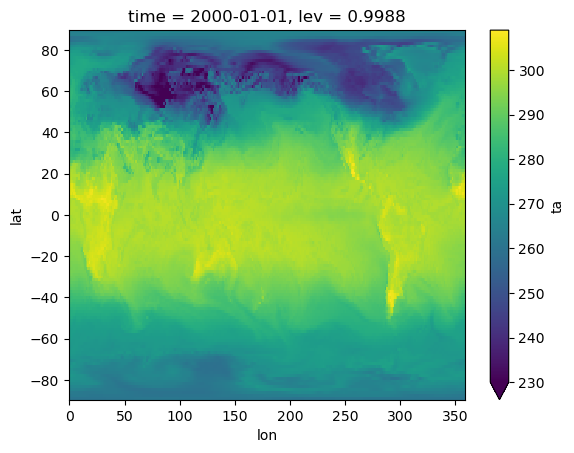

In [8]:
interpolated_era5_da[0,0,:,:].plot(vmin = 230)